## ASEAN Countries CO₂ Emission Forecast (with Auto Polynomial Selection)
Data Sources: Global Carbon Budget (2024)Population based on various sources (2024) – with major processing by Our World in Data

In [68]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")


In [69]:
# Load dataset
df = pd.read_csv("co2_emission_asean_clean.csv")
df.head()


,country,year,co2_per_capita
0,Cambodia,1955,0.020978
1,Cambodia,1956,0.026384
2,Cambodia,1957,0.031546
3,Cambodia,1958,0.037897
4,Cambodia,1959,0.039849


### Selecting the Best Polynomial Regression Model

To accurately model each country's CO₂ emission trends, we use **Polynomial Regression** — a technique that captures nonlinear relationships between year and CO₂ emissions per capita.

This function `fit_best_polynomial()` automatically tests polynomial degrees from 1 up to a defined limit (default: 5) and evaluates each model’s performance using **R²** and **RMSE** metrics.  
The model with the highest R² score is selected as the best fit for the dataset.


In [70]:
# Fit the best polynominal regression model
def fit_best_polynomial(X, y, max_degree=5):
    results = []
    best_model = None
    best_degree = None
    best_r2 = -np.inf
    
    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)
        
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        
        results.append((degree, r2, rmse))
        
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_degree = degree
            best_poly = poly
            
    return best_model, best_poly, best_degree, results


In [71]:
# Model fitting and evaluation
country = "Indonesia"
c_df = df[df["country"] == country].dropna(subset=["co2_per_capita"])

X = c_df["year"].values.reshape(-1, 1)
y = c_df["co2_per_capita"].values

model, poly, best_degree, results = fit_best_polynomial(X, y, max_degree=5)

print(f"Best degree for {country}: {best_degree}")
pd.DataFrame(results, columns=["Degree", "R2", "RMSE"])


Best degree for Indonesia: 3


,Degree,R2,RMSE
0,1,0.728127,0.350583
1,2,0.933704,0.173122
2,3,0.979234,0.096891
3,4,0.979049,0.097323
4,5,0.978849,0.097784


### Forecast Generation

After identifying the best polynomial model for each country, we project future CO₂ emissions per capita up to the year **2045**.  
Using the trained polynomial regression model, we generate predictions (`future_pred`) based on future year values (`future_years`) and store the results in a new dataframe `forecast_df`.


In [72]:
# Forecast generation 
future_years = np.arange(df["year"].max() + 1, 2045).reshape(-1, 1)
future_poly = poly.transform(future_years)
future_pred = model.predict(future_poly)

forecast_df = pd.DataFrame({
    "Year": future_years.flatten(),
    "Predicted_CO2_per_capita": future_pred
})


In [73]:
# Model evaluation (on historical data only)
y_pred = model.predict(poly.transform(X))  
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"{country} — Polynomial Degree {best_degree}")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


Indonesia — Polynomial Degree 3
R² Score: 0.979
RMSE: 0.097


### Trend and Forecast Visualization


In [74]:
# Predict next 20 years
future_years = np.arange(df["year"].max() + 1, 2045).reshape(-1, 1)
future_poly = poly.transform(future_years)
future_pred = model.predict(future_poly)

# Combine for visualization
forecast_df = pd.DataFrame({
    "year": future_years.flatten(),
    "Predicted_CO2_per_capita": future_pred
})


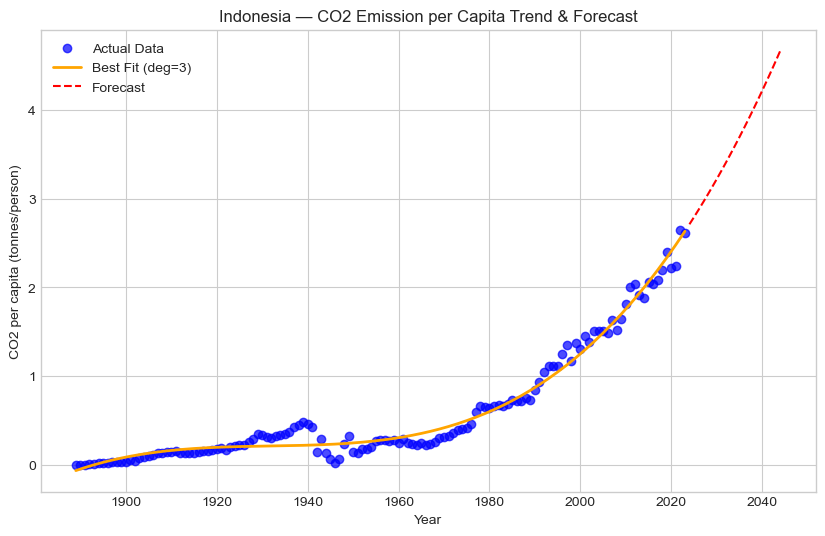

In [75]:
# Predict historical years for visualization
y_pred = model.predict(poly.transform(X))

plt.figure(figsize=(10,6))
plt.scatter(X, y, color="blue", alpha=0.7, label="Actual Data")
plt.plot(X, y_pred, color="orange", linewidth=2, label=f"Best Fit (deg={best_degree})")
plt.plot(future_years, future_pred, color="red", linestyle="--", label="Forecast")
plt.title(f"{country} — CO2 Emission per Capita Trend & Forecast")
plt.xlabel("Year")
plt.ylabel("CO2 per capita (tonnes/person)")
plt.legend()
plt.show()


### Modeling and Forecasting for All ASEAN Countries

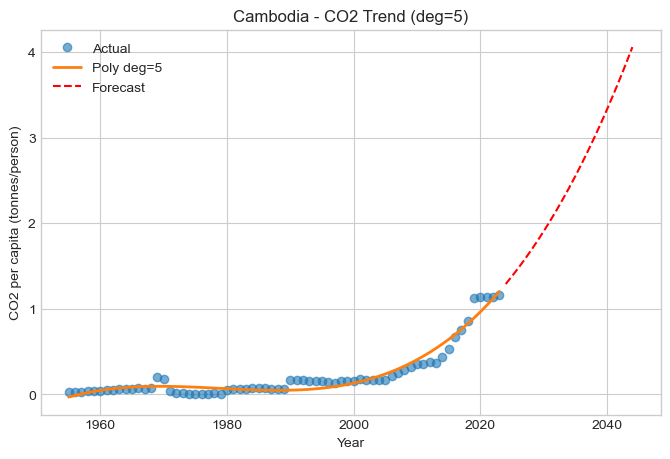

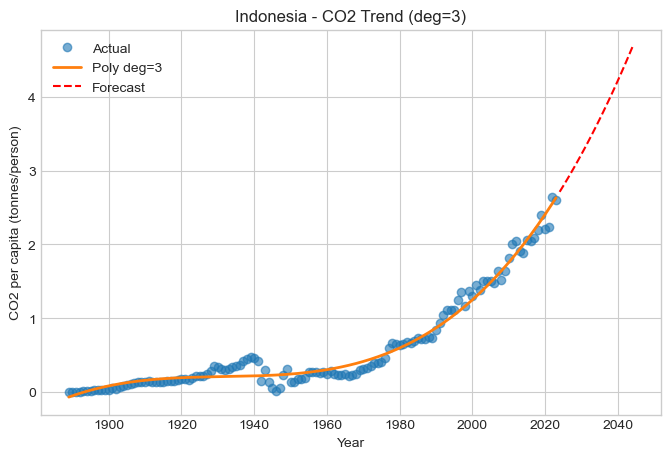

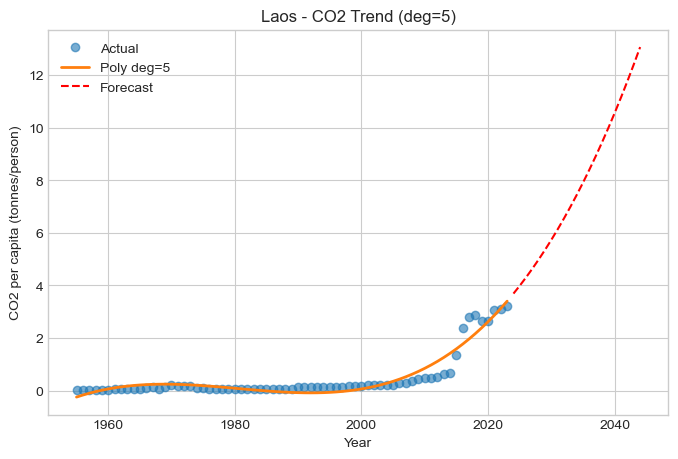

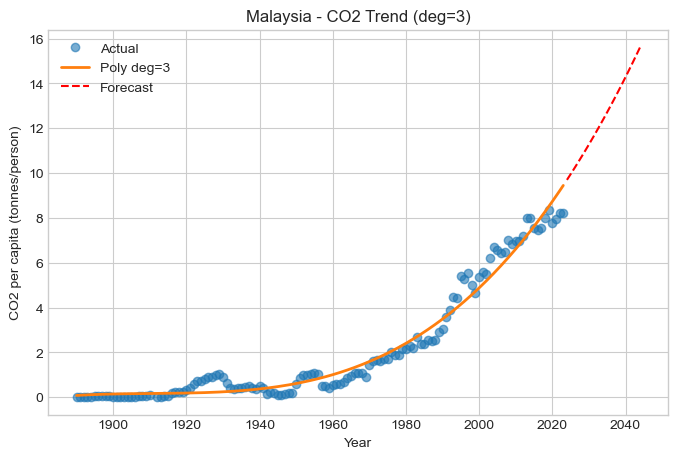

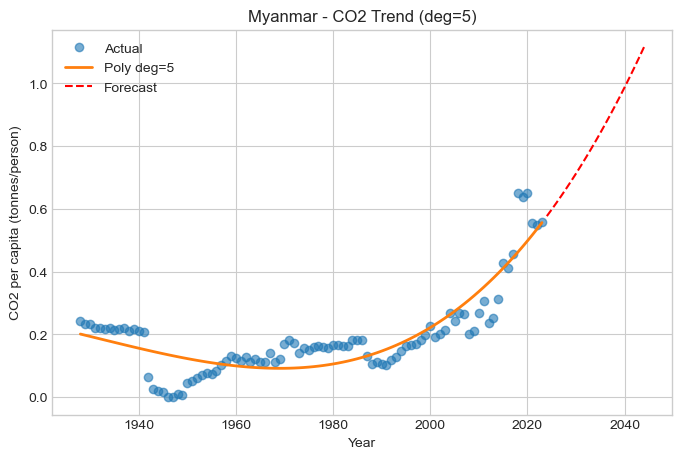

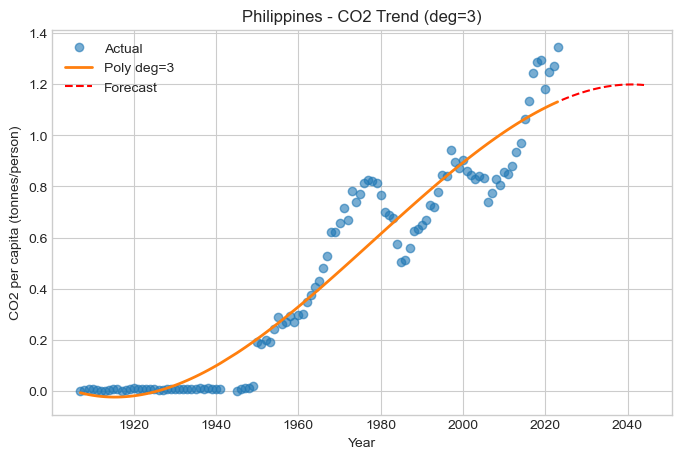

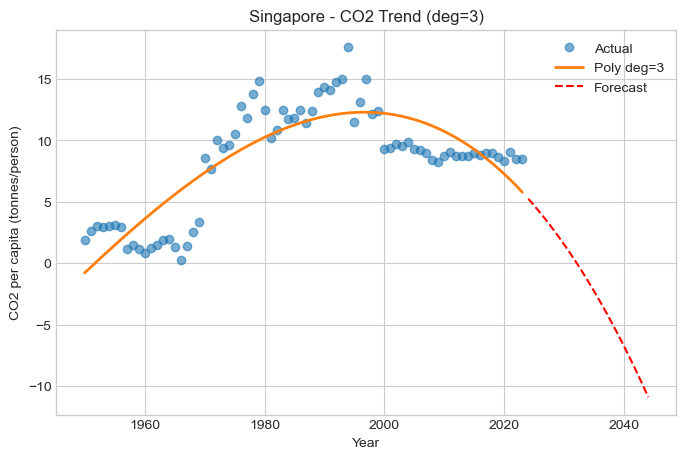

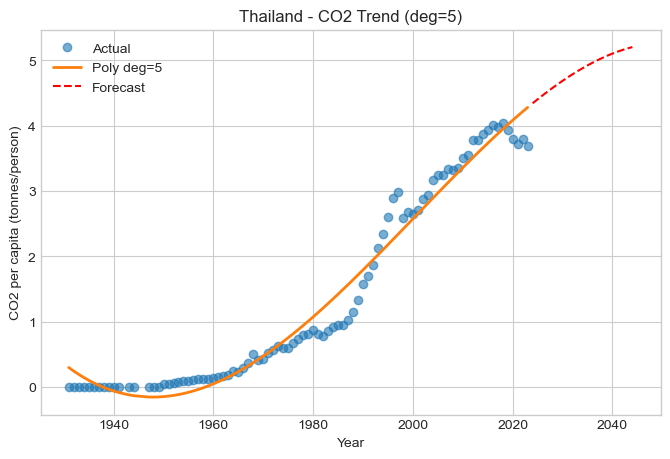

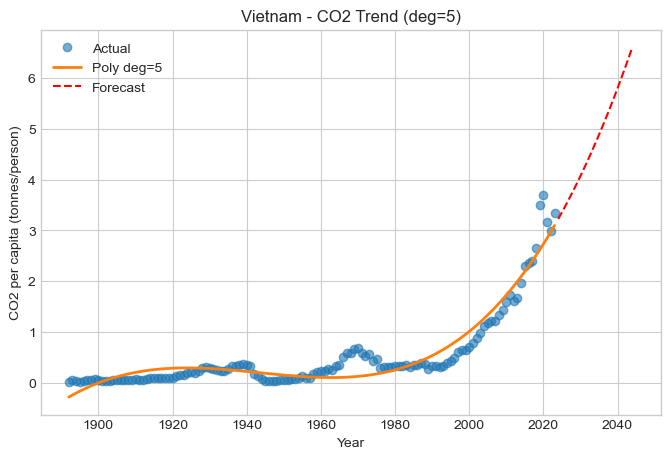

In [76]:
countries = df["country"].unique()
forecast_list = []

for country in countries:
    c_df = df[df["country"] == country].dropna(subset=["co2_per_capita"])
    X = c_df["year"].values.reshape(-1, 1)
    y = c_df["co2_per_capita"].values
    
    model, poly, best_degree, results = fit_best_polynomial(X, y, max_degree=5)
    y_pred = model.predict(poly.transform(X))
    
    # Forecast future years
    future_years = np.arange(df["year"].max() + 1, 2045).reshape(-1, 1)
    future_pred = model.predict(poly.transform(future_years))
    
    # Store results
    temp_df = pd.DataFrame({
        "Country": country,
        "Year": future_years.flatten(),
        "Predicted_CO2_per_capita": future_pred,
        "Best_degree": best_degree
    })
    forecast_list.append(temp_df)
    
    # Visualization
    plt.figure(figsize=(8,5))
    plt.plot(X, y, 'o', alpha=0.6, label="Actual")
    plt.plot(X, y_pred, '-', linewidth=2, label=f"Poly deg={best_degree}")
    plt.plot(future_years, future_pred, '--', color="red", label="Forecast")
    plt.title(f"{country} - CO2 Trend (deg={best_degree})")
    plt.xlabel("Year")
    plt.ylabel("CO2 per capita (tonnes/person)")
    plt.legend()
    plt.show()

forecast_all = pd.concat(forecast_list)


In [77]:
# Exporting forecast result
forecast_all.to_csv("co2_emission_forecast_auto_poly.csv", index=False)


### ASEAN CO2 Emission per Capita: Historical and Forecast

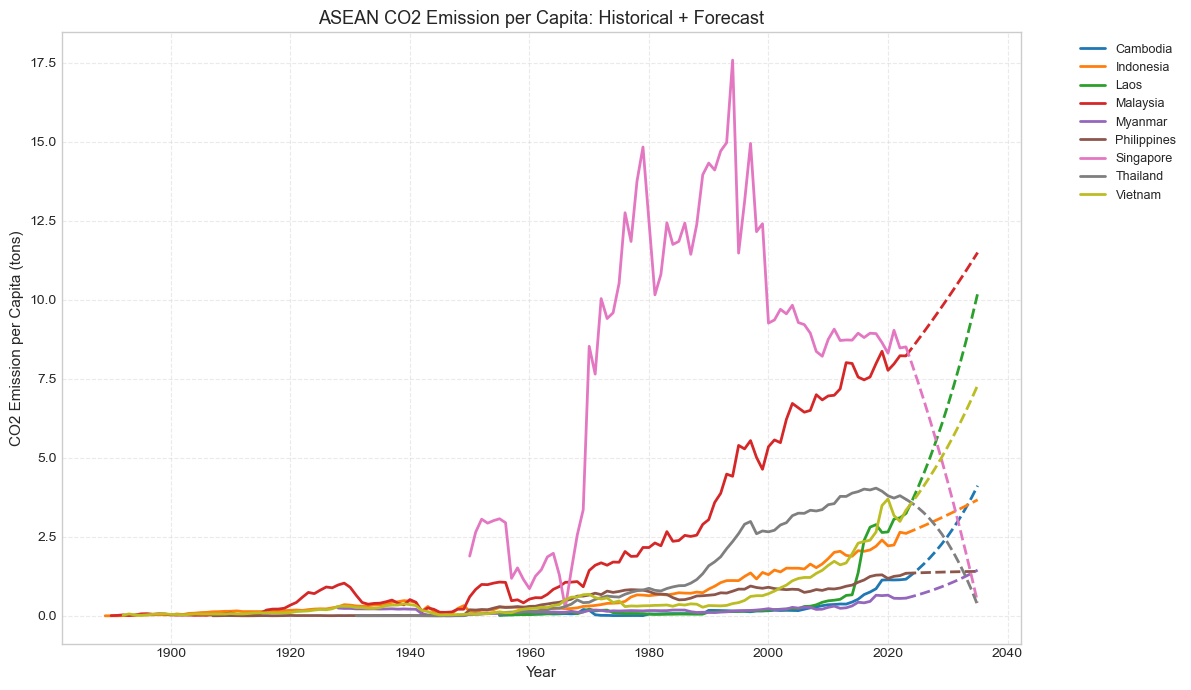

In [78]:
# Plotting the CO2 emission per capita 
plt.figure(figsize=(12, 7))

for country in df["country"].unique():
    c_df = df[df["country"] == country]
    degree = int(forecast_all[forecast_all["Country"] == country]["Best_degree"].iloc[0])

    X = c_df["year"].values
    y = c_df["co2_per_capita"].values

    poly = np.poly1d(np.polyfit(X, y, degree))

    last_year = X.max()
    last_value = y[-1] 

    future_years = np.arange(last_year, 2036)
    future_pred = poly(future_years)

    offset = last_value - future_pred[0]
    future_pred = future_pred + offset

    future_pred = np.where(future_pred < 0, 0, future_pred)

    line, = plt.plot(X, y, label=f"{country}", linewidth=2)
    color = line.get_color()

    plt.plot(future_years, future_pred, linestyle="--", color=color, linewidth=2)

plt.xlabel("Year", fontsize=11)
plt.ylabel("CO2 Emission per Capita (tons)", fontsize=11)
plt.title("ASEAN CO2 Emission per Capita: Historical + Forecast", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()